This notebook will walk through the process of fitting $P(\nu,A)$ data to the England and Rider evaluation. The script `fit_P_nu_A.py` can be used to apply this same code to every fissioning system in the `yields` folder.  

First define the fissioning system that will be analyzed (see `yields/<evaluation>/systems.txt` for a full list of systems):

In [1]:
system = 'U235F'
evaluation = 'ENDF'
Ap = 236
Zp = 92

Import statements:

In [2]:
import numpy
numpy.random.seed(0)
import scipy
from math import erfc
from math import erf
from math import sqrt
from math import exp
from math import pi
from math import isnan
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'figure.autolayout': True})
from decimal import Decimal
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

The following functions are defined and used in the fitting process, read the docstrings on each for more information:

In [3]:
def gauss_trunc(x,mu,sigma):
    """
    Truncated Gaussian function
    x = point along distribution
    mu = centroid of distribution
    sigma = width of distribution 
    """
    #norm = 1.0 / ( 1.0 - ( erfc( mu * sqrt( 1.0 / sigma**2.0 ) / sqrt(2.0) ) / ( 2.0 * mu * sqrt( 1.0 / sigma**2.0 ) ) ) )
    norm = 1.0 / ( 0.5 + 0.5 * erf( mu / (sqrt(2.0)*sigma) ) )
    return norm * ( 1.0 / (sigma * sqrt(2.0*pi)) ) * numpy.exp( -0.5 * ((x-mu)/sigma)**2.0 )

def gauss_trunc_integ(b,c,mu,sigma):
    """
    Definite integral of truncated Gaussian function
    x = point along distribution
    mu = centroid of distribution
    sigma = width of distribution 
    """
    norm = 1.0 / ( 0.5 + 0.5 * erf( mu / (sqrt(2.0)*sigma) ) )
    K = norm * ( 1.0 / (sigma * sqrt(2.0*pi)) )
    return K * sqrt(pi/2.0) * sigma * ( scipy.special.erf( (mu-b)/(sqrt(2.0)*sigma) ) - scipy.special.erf( (mu-c)/(sqrt(2.0)*sigma) ) ) 

def gauss_trunc_int(nu,mu,sigma,mid=0.5):
    """
    Integer value of truncated Gaussian
    nu = integer point of distribution
    mu = centroid of distribution
    sigma = width of distribution 
    mid = midway point to integrate over (nu-(1-mid),nu+mid)
    """
    nu = int(nu)

    lower = nu-(1.0-mid)
    if(lower < 0.0):
        lower = 0.0
    upper = nu+mid

    return gauss_trunc_integ(lower,upper,mu,sigma)

def gauss_trunc_bar(mu,sigma,h=0.001,upper=20):
    """
    Get the expectation value of a truncated Gaussian
    mu = centroid of distribution
    sigma = width of distribution 
    h = integration constant
    upper = max value to integrate up to
    """
    val = 0.0
    for x in numpy.arange(0,upper,h):
        val += gauss_trunc_integ(x,x+h,mu,sigma) * (x+(h/2.0))

    return val

def chi2A(x,ACUR,ACN,YIELDS,return_yields=False):
    """
    Function to calculate chi2 for P_nu_A distribution against ER yields
    Single A chain
    """
    mu = x[0]
    sigma = x[1]
    nu_max = 10
    A_upper = ACN - ACUR
    A_lower = ACN - ACUR - nu_max

    #Calculate yields in A chain
    yields_new = {}
    for key in YIELDS.keys():
        if( (key[1] >= A_lower) and (key[1] <= A_upper) ):
            for j in range(0,nu_max):
                if( (ACN-key[1]-j) == ACUR ):
                    try:
                        yields_new[ZCN-key[0],ACN-key[1]-j] += gauss_trunc_int(j,mu,sigma) * YIELDS[key]
                    except KeyError as e:
                        yields_new[ZCN-key[0],ACN-key[1]-j] = gauss_trunc_int(j,mu,sigma) * YIELDS[key]

    #Calculate chi2
    chi2 = 0.0
    for key in yields_new.keys():
        try:
            chi2 += ( YIELDS[key] - yields_new[key] )**2.0 / YIELDS[key]
        except KeyError as e:
            pass

    if( return_yields ):
        return chi2, yields_new
    else:
        return chi2
    
def chi2A_fit(ACUR,ACN,YIELDS):
    """
    Function to perform differential evolution of data to chi2A
    """
    guess = [ (0.01,5.0), (0.01,3.0) ]
    fit_P_nu_A = differential_evolution( chi2A, guess, args=(ACUR,ACN,YIELDS) )
    fit_P_nu_A = fit_P_nu_A.x
    chi2 = chi2A(fit_P_nu_A,ACUR,ACN,YIELDS)
    
    return fit_P_nu_A, chi2

def chi2A_mod(P_nu_A,ACUR,ACN,YIELDS,return_yields=False):
    """
    Function to calculate chi2 for P_nu_A distribution against ER yields
    Single A chain
    """
    nu_max = 10
    A_upper = ACN - ACUR
    A_lower = ACN - ACUR - nu_max

    #Calculate yields in A chain
    yields_new = {}
    for key in YIELDS.keys():
        if( (key[1] >= A_lower) and (key[1] <= A_upper) ):
            for j in range(0,nu_max):
                if( (ACN-key[1]-j) == ACUR ):
                    try:
                        yields_new[ZCN-key[0],ACN-key[1]-j] += P_nu_A[key[1]][j] * YIELDS[key]
                    except KeyError as e:
                        yields_new[ZCN-key[0],ACN-key[1]-j] = P_nu_A[key[1]][j] * YIELDS[key]

    #Calculate chi2
    chi2 = 0.0
    for key in yields_new.keys():
        try:
            chi2 += ( YIELDS[key] - yields_new[key] )**2.0 / YIELDS[key]
        except KeyError as e:
            pass

    if( return_yields ):
        return chi2, yields_new
    else:
        return chi2

Read in the yields from file: 

In [4]:
file = open( 'yields/' + evaluation + '/independent/' + system + '.csv', 'r' )
lines = file.readlines()
file.close()
A_min = 300
A_max = 0
yields = {}
yields_unc = {}
for line in lines:
    parts = line.split(',')
    Z = int( parts[0] )
    A = int( parts[1] )
    I = int( parts[2] )
    Y = float( parts[3] )
    Y_unc = float( parts[4] )
    if( A < A_min ):
        A_min = A
    if( A > A_max ):
        A_max = A
    if( I == 0 ):
        try:
            yields[Z,A] += Y
            yields_unc[Z,A] += Y_unc**2.0
        except KeyError as e:
            yields[Z,A] = Y
            yields_unc[Z,A] = Y_unc**2.0
YIELDS = yields
for key in yields_unc:
    yields_unc[key] = sqrt( yields_unc[key] )
YIELDS_UNC = yields_unc
ZCN = Zp
ACN = Ap
AMIN = A_min
AMID = int( (A_max - A_min)/2.0 ) + A_min
AMAX = A_max

Now fit $P(\nu,A)$ data for each $A$ chain: 

In [5]:
fits = {}
chi2s_before = []
flags = []
fit_last = None
guess = [ (0.01,5.0), (0.01,3.0) ]

for ACUR in range(AMIN,AMAX+1):
    #Fit values
    fit_P_nu_A, chi2 = chi2A_fit(ACUR,ACN,YIELDS)
    flag = 0
    chi2A(fit_P_nu_A,ACUR,ACN,YIELDS)

    #If fit railed on any of the edges, use last A's fit
    if( (fit_P_nu_A[0] == guess[0][0]) or (fit_P_nu_A[0] == guess[0][1]) or (fit_P_nu_A[1] == guess[1][0]) or (fit_P_nu_A[1] == guess[1][1]) or (chi2 == 0.0) ):
        if( fit_last[0] != None ):
            fit_P_nu_A = fit_last
            flag = 1
            chi2 = chi2A(fit_P_nu_A,ACUR,ACN,YIELDS)
    
    chi2s_before.append( chi2 )
    flags.append( flag )
    fits[ACUR] = fit_P_nu_A
    fit_last = fit_P_nu_A

Generate of table of $P(\nu,A)$ for $\nu$ = 0,1,...,9:

In [6]:
P_nu_A = {}
for A in range(AMIN,AMAX+1):
    P_nu = []
    for j in range(0,10):
        mu, sigma = fits[A]
        val = round( gauss_trunc_int(j,mu,sigma), 5 )
        P_nu.append( val )
    
    norm = 1.0/sum(P_nu)
    for j in range(0,10):
        P_nu[j] = P_nu[j] * norm
    
    P_nu_A[A] = P_nu

Plot the $\bar{\nu}(A)$ that results from this fitting:

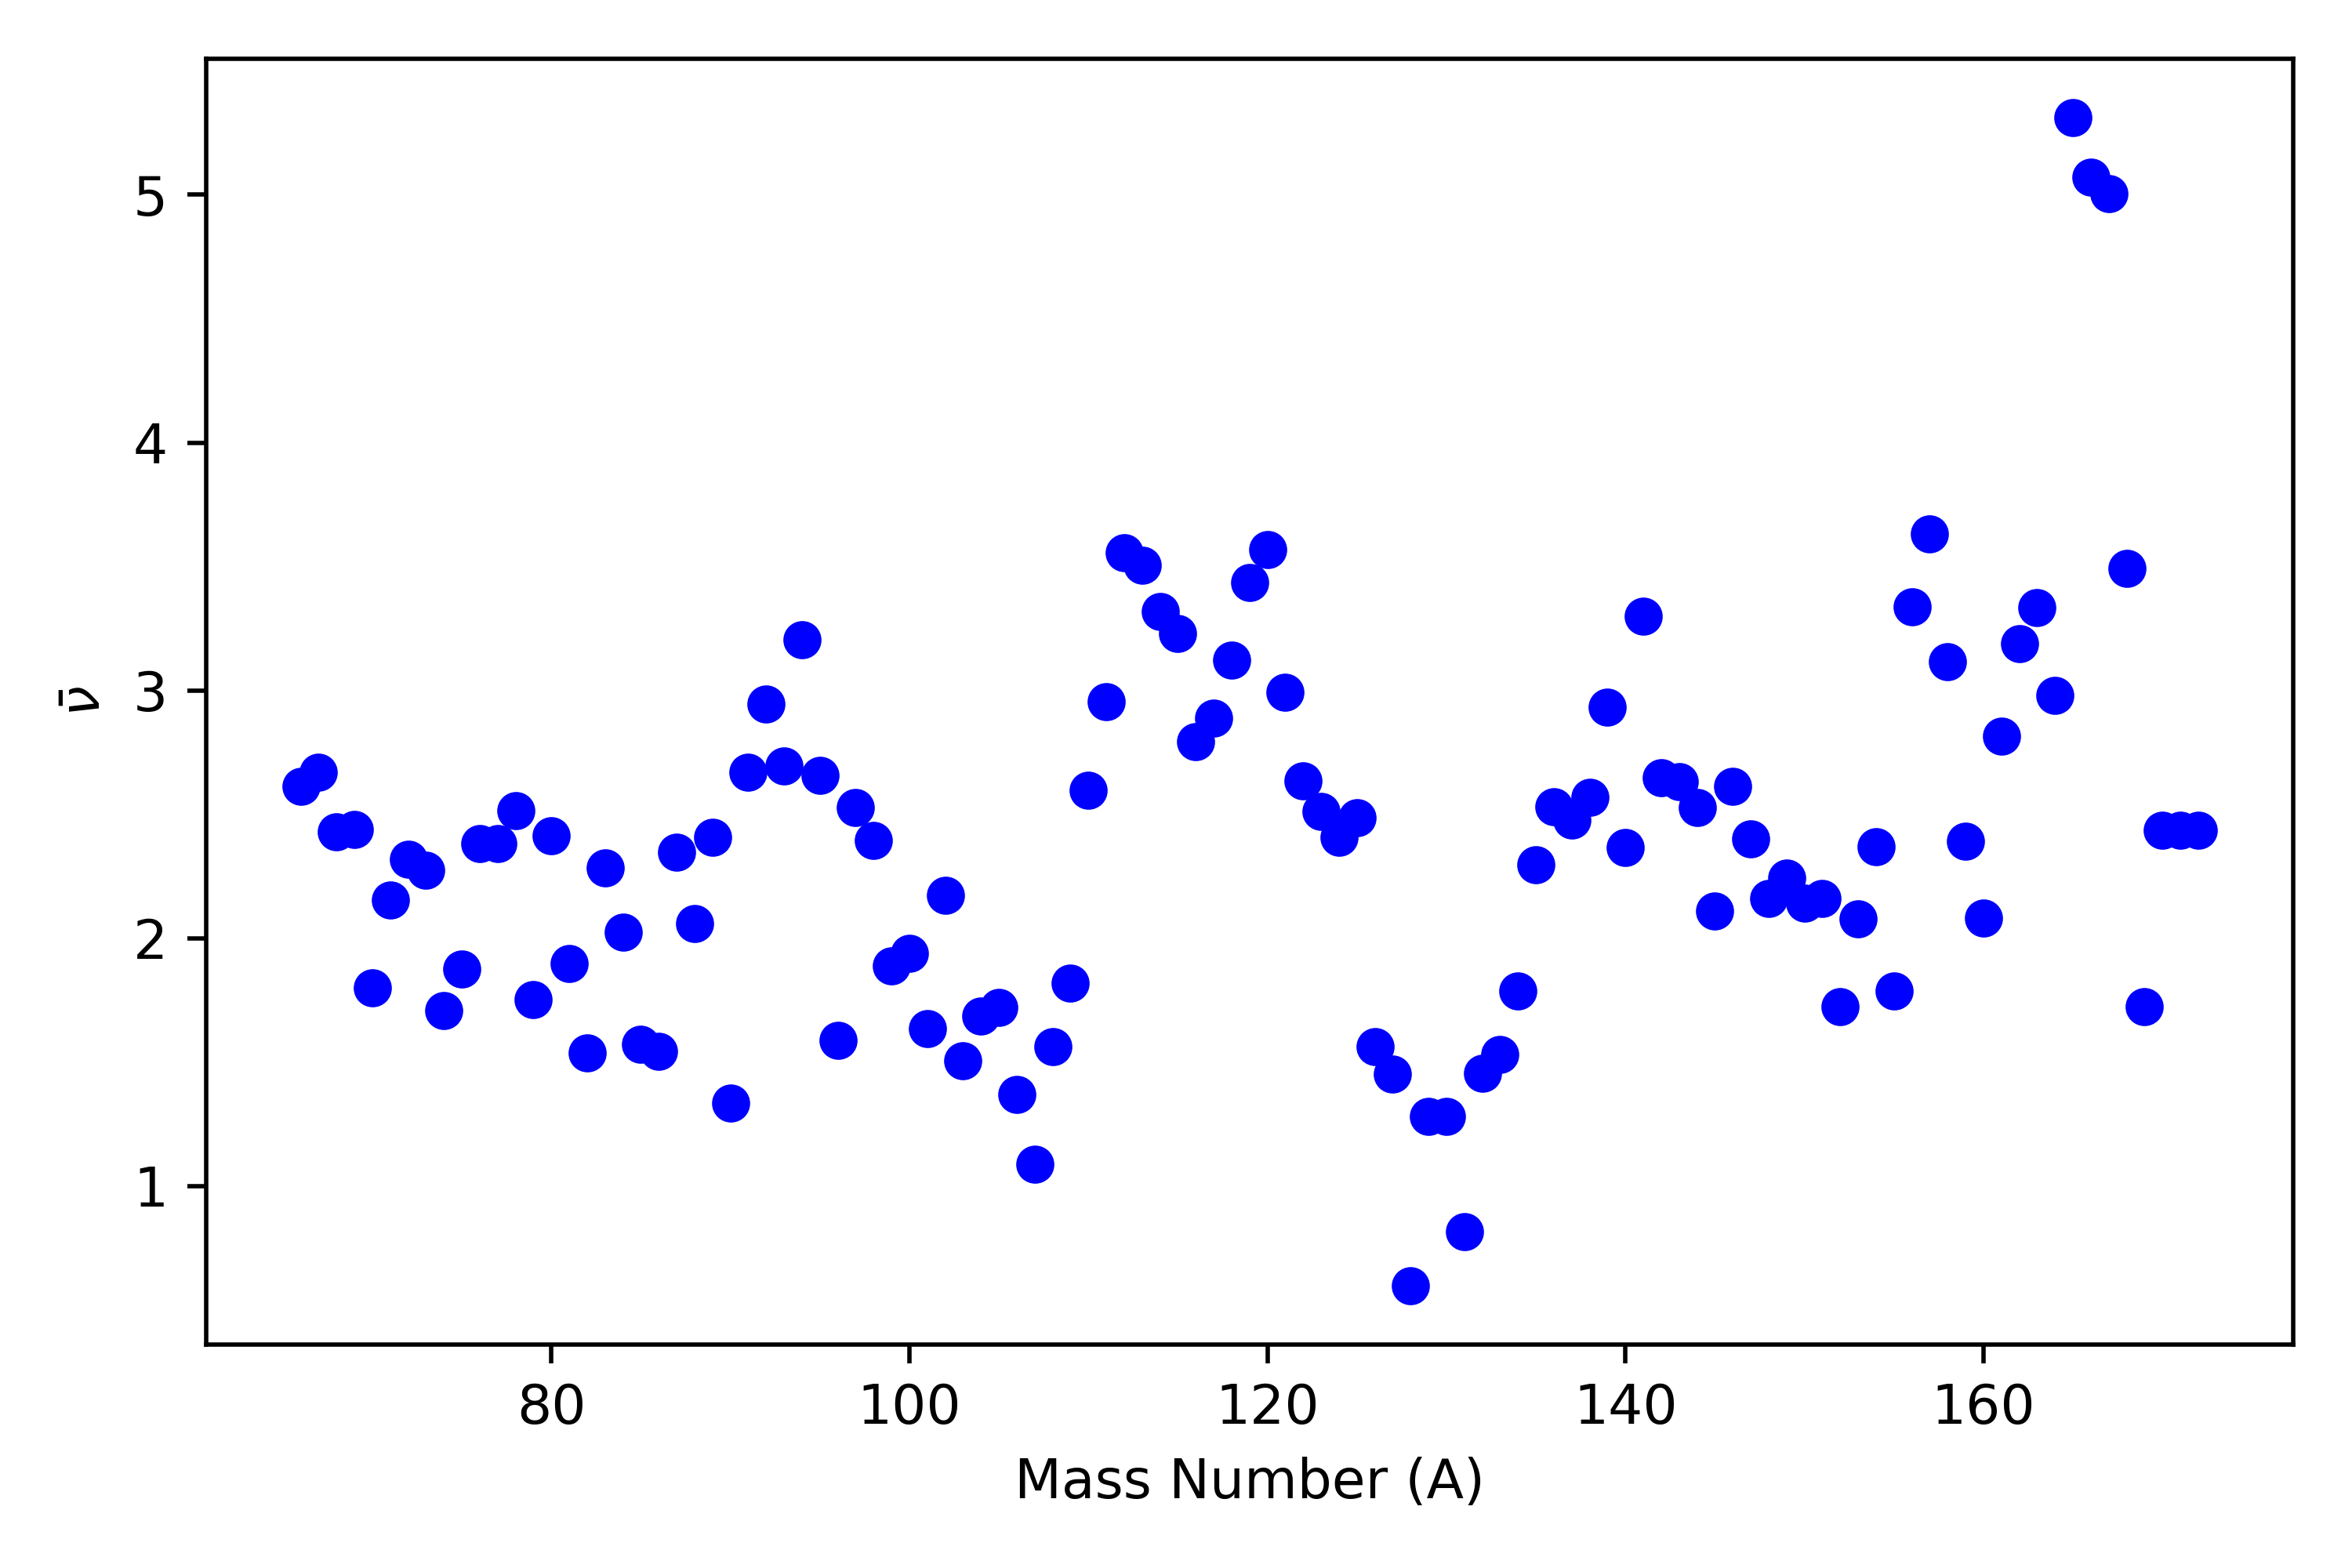

<Figure size 432x288 with 0 Axes>

In [7]:
nu_bars = []
for A in range(AMIN,AMAX+1):
    nu_bar = gauss_trunc_bar( *fits[A] )
    nu_bars.append( nu_bar )

plt.plot( range(AMIN,AMAX+1), nu_bars, 'bo' )
plt.xlabel( 'Mass Number (A)' )
plt.ylabel( r'$\bar{\nu}$' )
plt.savefig( 'yields/' + evaluation + '/P_nu_A/nu_reports/' + system + '_nu_bar.eps', format='eps' )
plt.savefig( 'yields/' + evaluation + '/P_nu_A/nu_reports/' + system + '_nu_bar.png', dpi=500 )
plt.clf()
Image( 'yields/' + evaluation + '/P_nu_A/nu_reports/' + system + '_nu_bar.png' )

Ideally, the condition should be met that: 

\begin{equation}
P(\nu_i,A) = P(\nu_i,A_{CN}-A-\nu_i)
\end{equation}

In an attempted to address this, iteratively average $P(\nu_i,A)$ and $P(\nu_i,A_{CN}-A-\nu_i)$ values and renormalize each $P(\nu,A)$ until convergence is met. Round $P(\nu,A)$ values to 5 decimal places.

In [8]:
P_nu_A_new = {}
for A in range(AMIN,AMAX+1):
    P_nu_A_new[A] = P_nu_A[A][:]

converged = False
chi2_last = float('inf')
while( not(converged) ):
    #Average values
    for A in range(AMIN,AMAX+1):
        for j in range(0,10):
            P1 = P_nu_A_new[A][j]
            try:
                P2 = P_nu_A_new[ACN-A-j][j]
            except KeyError as e:
                continue
            new_val = (P1 + P2)/2.0
            new_val = round( new_val, 5 )
            P_nu_A_new[A][j] = new_val
            P_nu_A_new[ACN-A-j][j] = new_val
    
    #Renormalize
    for A in range(AMIN,AMAX+1):
        norm = 1.0/sum(P_nu_A_new[A])
        for j in range(0,10):
            val = P_nu_A_new[A][j] * norm
            val = round( val, 5 )
            P_nu_A_new[A][j] = val

    #Check if values have converged
    chi2 = 0.0
    for A in range(AMIN,AMAX+1):
        for j in range(0,10):
            P1 = P_nu_A_new[A][j]
            try:
                P2 = P_nu_A_new[ACN-A-j][j]
            except KeyError as e:
                continue
            if( P1 > 0.0 ):
                chi2 += (P1-P2)**2.0 / P1
    if( chi2_last == chi2 ):
        converged = True
    else:
        chi2_last = chi2

#Calculate chi2 for yields with adjusted P(nu,A) data
chi2s_after = []
for ACUR in range(AMIN,AMAX+1):
    chi2 = chi2A_mod(P_nu_A_new,ACUR,ACN,YIELDS)
    chi2s_after.append( chi2 )

#See how chi2 changes on average
perc_diff = sum( chi2s_after ) / sum( chi2s_before ) * 100.0
print( 'Change in chi2 = ' + str(perc_diff) + '%' )

Change in chi2 = 3890658989.890921%


This normalization process results in a drastic change to $\chi^2$, therefore continue to use the $P(\nu,A)$ data before renormalization. Save $P(\nu,A)$ data to file:

In [9]:
file = open( 'yields/' + evaluation + '/P_nu_A/' + system + '_nu_data.csv', 'w' )
for A in range(AMIN,AMAX+1):
    file.write( str(A) )
    for j in range(0,10):
        file.write( ', ' + str( P_nu_A[A][j] ) )
    file.write( '\n' )
file.close()

file = open( 'yields/' + evaluation + '/P_nu_A/nu_reports/' + system + '_fit.csv', 'w' )
file.write( 'A, mu, sigma, chi2_before, chi2_after, % change, flag\n' )
for A in range(AMIN,AMAX+1):
    file.write( str(A) )
    for j in range(0,2):
        file.write( ', ' + str( fits[A][j] ) )
    file.write( ', ' + str(chi2s_before[A-AMIN]) )
    file.write( ', ' + str(chi2s_after[A-AMIN]) )
    try:
        perc_diff = 100.0*(chi2s_after[A-AMIN] - chi2s_before[A-AMIN])/chi2s_before[A-AMIN]
    except ZeroDivisionError as e:
        perc_diff = float('nan')
    file.write( ', ' + str( perc_diff ) )
    file.write( ', ' + str(flags[A-AMIN]) )
    file.write('\n')
file.close()

Plot $\bar{\nu}(A)$ after this renormalization:

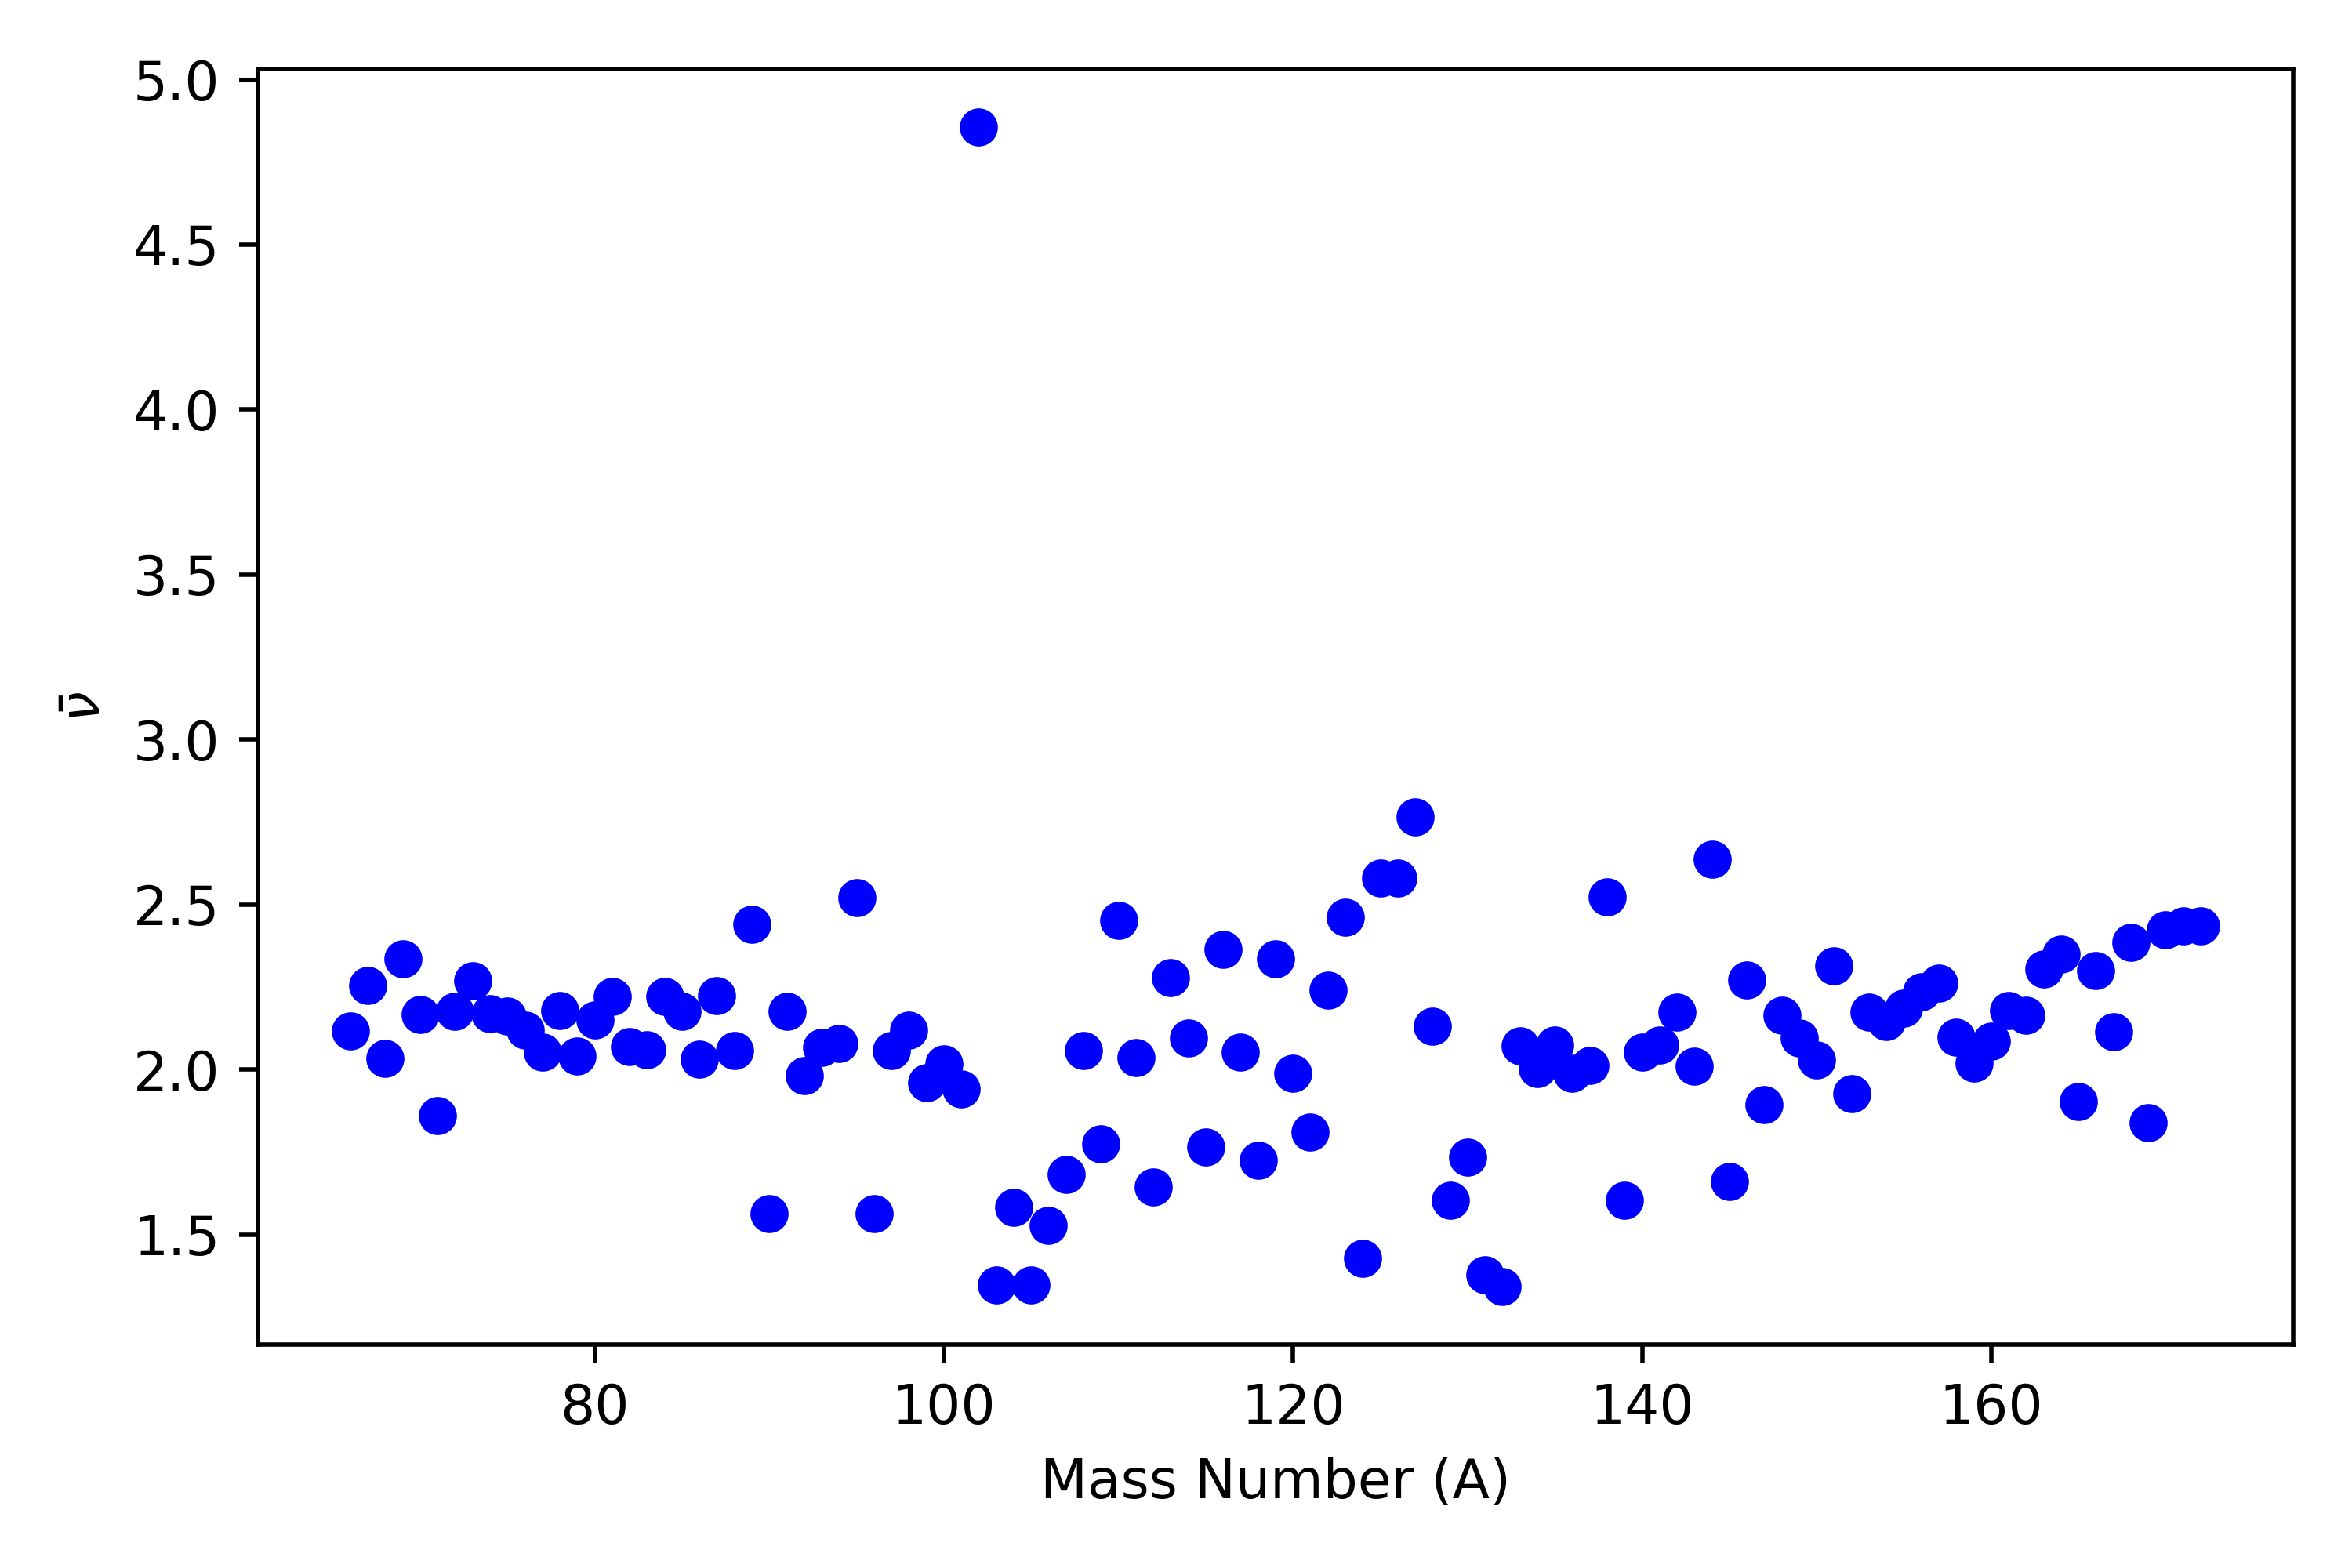

<Figure size 432x288 with 0 Axes>

In [10]:
nu_bars_new = []
for A in range(AMIN,AMAX+1):
    nu_bar = 0.0
    for j in range(0,10):
        nu_bar += j * P_nu_A_new[A][j]
    nu_bars_new.append( nu_bar )

plt.plot( range(AMIN,AMAX+1), nu_bars_new, 'bo' )
plt.xlabel( 'Mass Number (A)' )
plt.ylabel( r'$\bar{\nu}$' )
plt.savefig( 'yields/' + evaluation + '/P_nu_A/nu_reports/' + system + '_nu_bar_new.eps', format='eps' )
plt.savefig( 'yields/' + evaluation + '/P_nu_A/nu_reports/' + system + '_nu_bar_new.png', dpi=500 )
plt.clf()
Image( 'yields/' + evaluation + '/P_nu_A/nu_reports/' + system + '_nu_bar_new.png' )

Plot yield residuals:

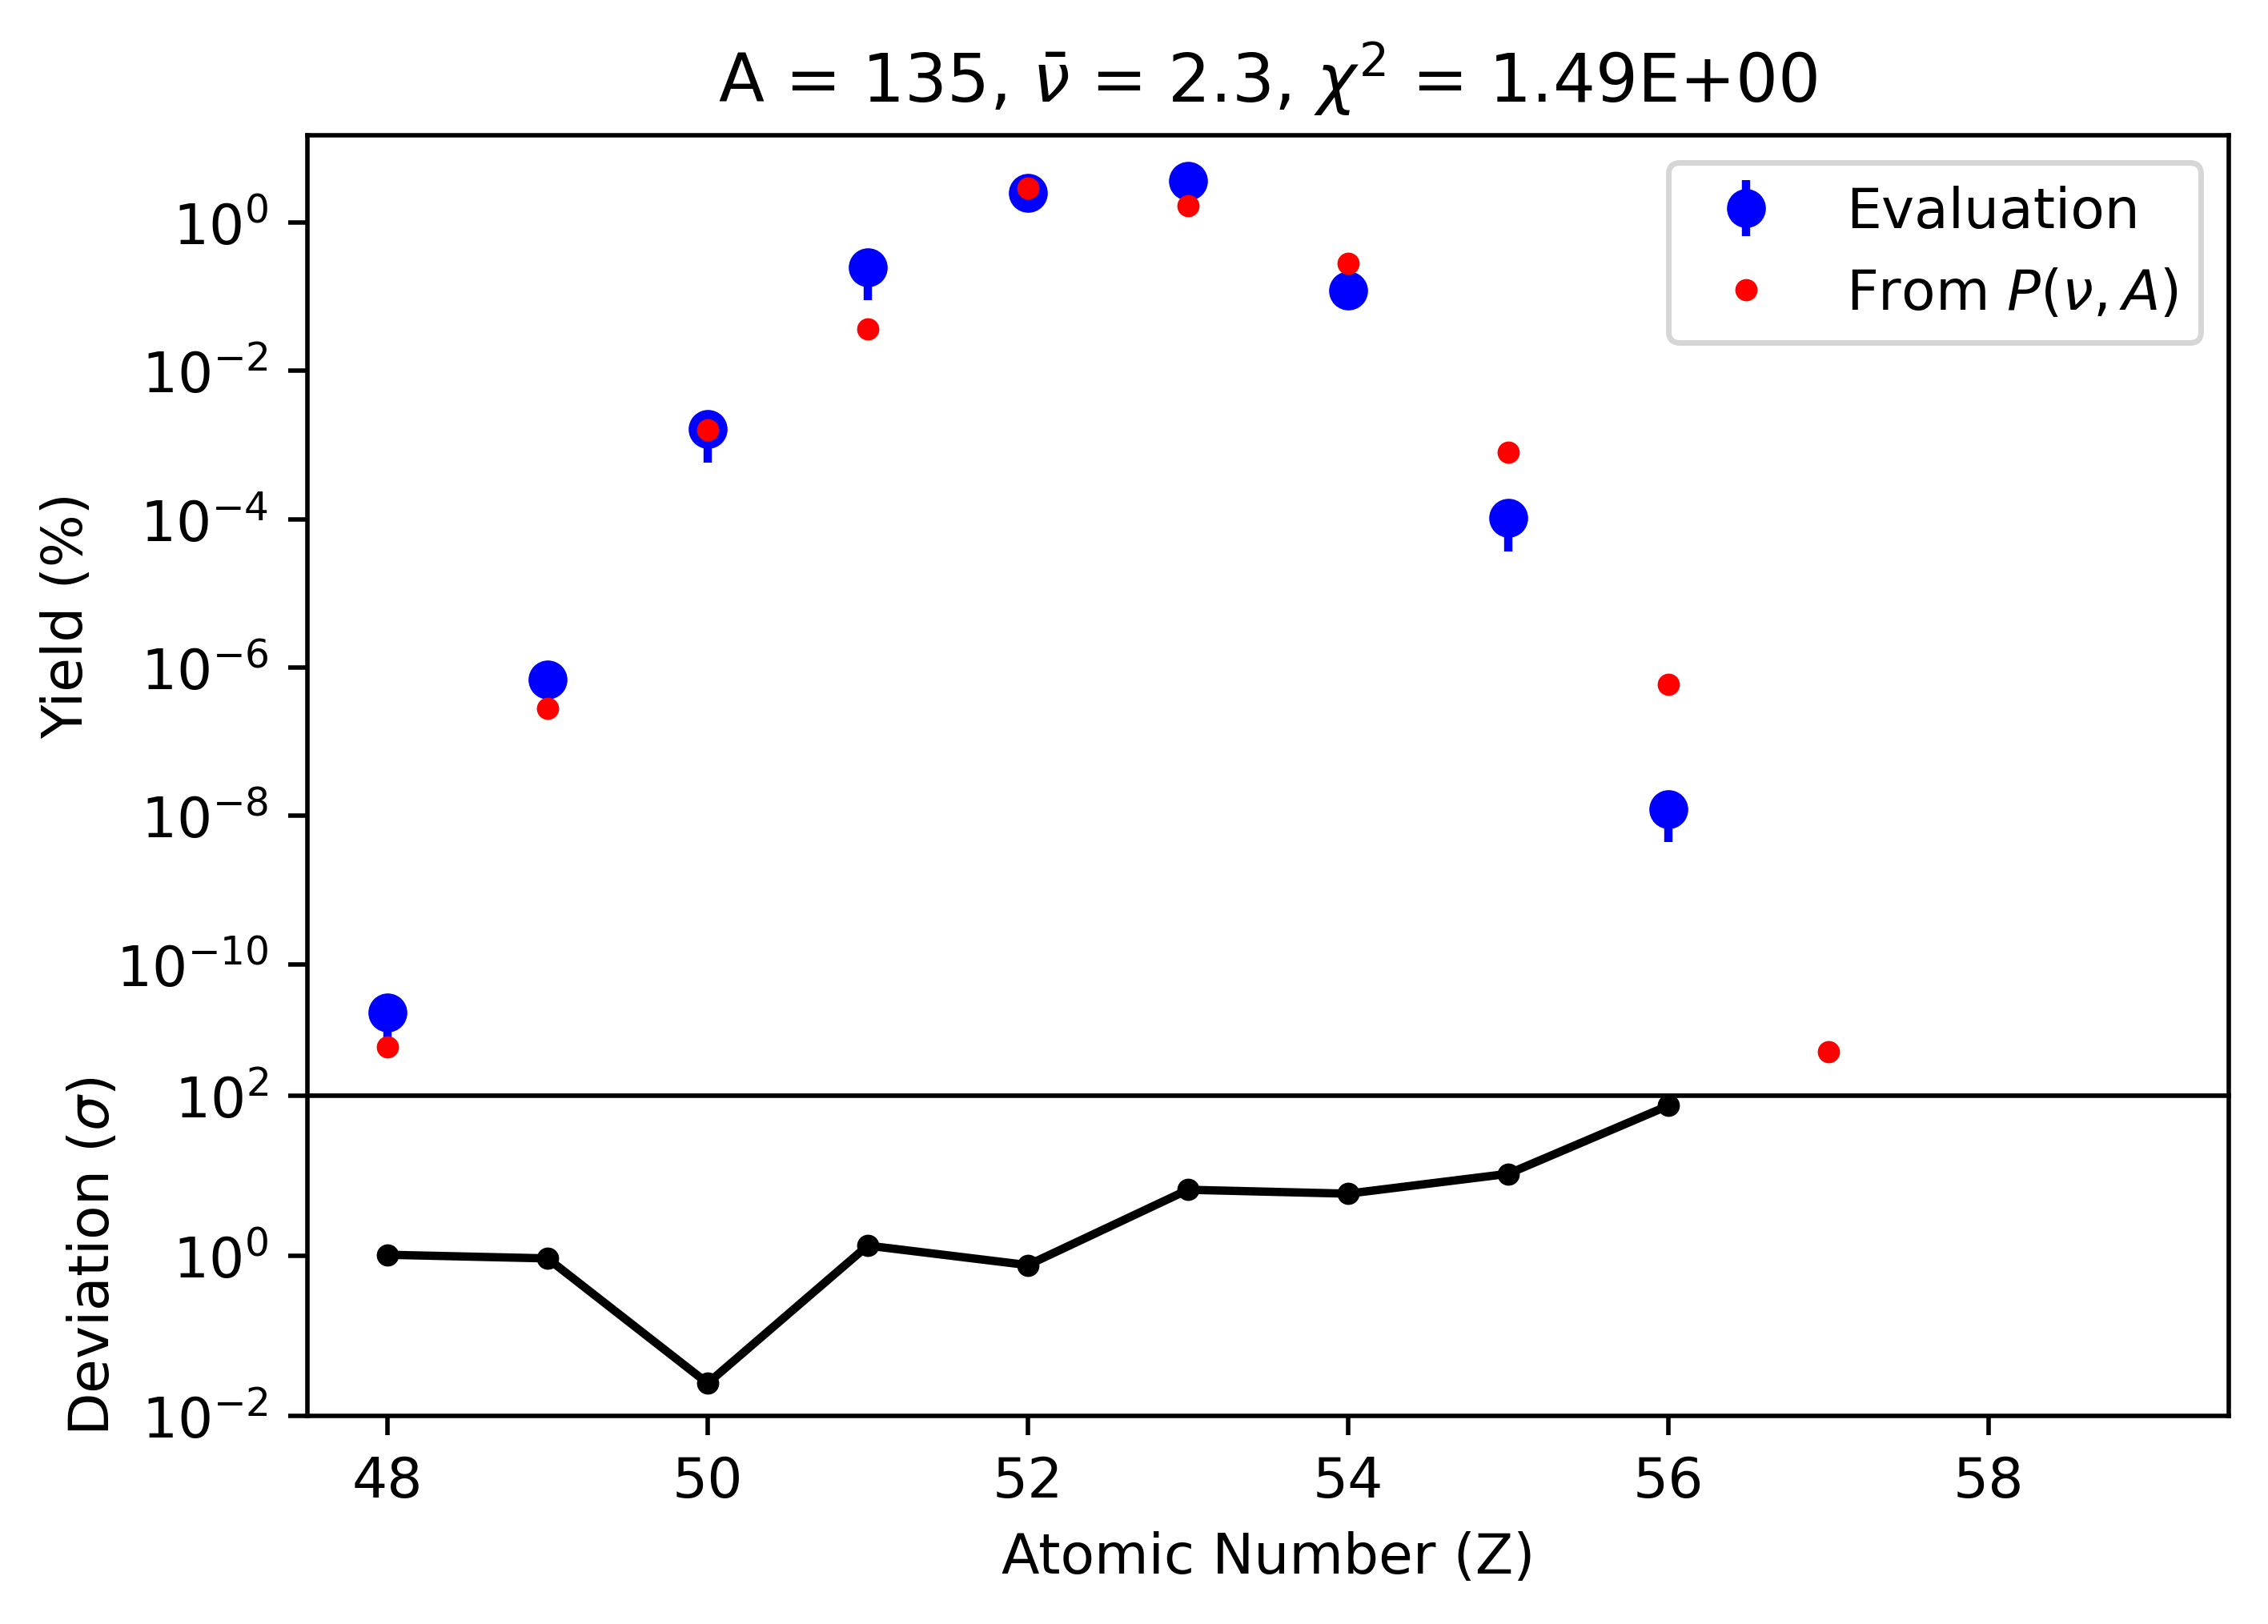

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
for ACUR in range(AMIN,AMAX+1):
    chi2, yields_new = chi2A_mod( P_nu_A, ACUR, ACN, YIELDS, return_yields=True )

    Zs = []
    yields_new_vals = []
    yields_old_vals = []
    yields_old_vals_unc = []
    stdevs = []
    for key in yields_new.keys():
        Zs.append( key[0] )
        yields_new_vals.append( yields_new[key] )
        try:
            yields_old_vals.append( YIELDS[key] )
            yields_old_vals_unc.append( YIELDS_UNC[key] )
            stdev = abs((YIELDS[key] - yields_new[key])/YIELDS_UNC[key])
            stdevs.append( stdev )
        except KeyError as e:
            yields_old_vals.append( 0.0 )
            yields_old_vals_unc.append( 0.0 )
            stdevs.append( float('nan') )
    if( len(Zs) == 0 ):
        continue

    fig = plt.figure()
    frame1 = fig.add_axes((.1,.3,.8,.6))
    plt.errorbar( Zs, yields_old_vals, yerr=yields_old_vals_unc, fmt='bo', label='Evaluation' )
    plt.errorbar( Zs, yields_new_vals, fmt='r.', label=r'From $P(\nu,A)$' )
    plt.ylabel( 'Yield (%)' )
    plt.title( 'A = ' + str(ACUR) + ', ' + r'$\bar{\nu}$' + ' = ' + str(round(gauss_trunc_bar(*fits[ACUR]),2)) + ', ' + r'$\chi^2$' + ' = ' + ('%.2E' % Decimal(str(chi2))) )
    plt.xlim( (min(Zs)-0.5,max(Zs)+0.5) )
    plt.yscale( 'log' )
    plt.legend()
    frame2 = fig.add_axes((.1,.1,.8,.2))
    plt.plot( Zs, stdevs, 'k.-' )
    plt.xlabel( 'Atomic Number (Z)' )
    plt.ylabel( r'Deviation ($\sigma$)' )
    plt.xlim( (min(Zs)-0.5,max(Zs)+0.5) )
    plt.ylim( (1e-2,1e2) )
    plt.yscale( 'log' )
    plt.savefig( 'yields/' + evaluation + '/P_nu_A/residuals/' + system + '_' + str(ACUR) + '.png', dpi=500, bbox_inches='tight' )
    plt.clf()

Image( 'yields/' + evaluation + '/P_nu_A/residuals/' + system + '_135.png' )